In [198]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Экстраполируем население Камеруна

## Возьмём известные данные о численности начеления Камеруна

| год, Y | численность населения, N |
|--------|--------------------------|
|  1950  |         4466000          |
|  1955  |         4901000          |
|  1960  |         5409000          |
|  1965  |         6049000          |
|  1970  |         6842000          |
|  1975  |         7838000          |
|  1980  |         9110000          |
|  1985  |        10519000          |
|  1990  |        12181000          |
|  1995  |        13940000          |
|  2000  |        15678000          |
|  2005  |        17554000          |
|  2010  |        19599000          |

[Источник](https://en.wikipedia.org/wiki/Demographics_of_Cameroon)

### Экстраполируем данные с помощью классической полиномиалной интерполяции методом Ньютона

In [199]:
# Загрузка данных

data = {
    1950 : 4466000,
    1955 : 4901000,
    1960 : 5409000,
    1965 : 6049000,
    1970 : 6842000,
    1975 : 7838000,
    1980 : 9110000,
    1985 : 10519000,
    1990 : 12181000,
    1995 : 13940000,
    2000 : 15678000,
    2005 : 17554000,
    2010 : 19599000,
}

N = len(data)

START = 1950
STEP = 5

extraploation_result = {}

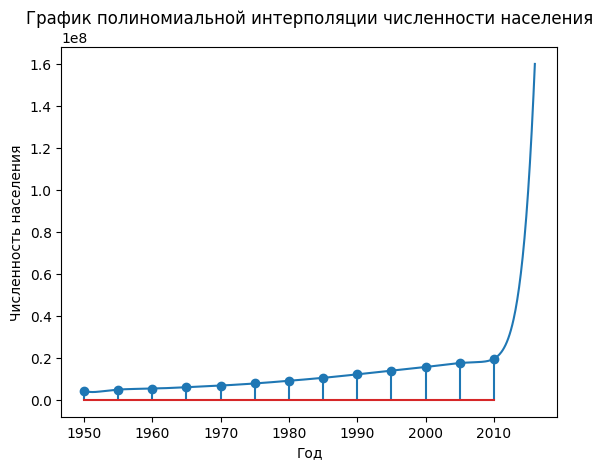

98651000.00000012


In [200]:
# Классическая полиномиальная интерполяция методом Ньютона

# Построение разделённых разностей

divided_diffs = {}

for j in range(len(data)):
    divided_diffs[f"{j}"] = data[START + j * STEP]

for i in range(2, len(data) + 1):
    for j in range(len(data) - i + 1):
        divided_diffs['_'.join([f'{j + k}' for k in range(i)])] = (divided_diffs['_'.join([f'{j + k + 1}' for k in range(i - 1)])] - divided_diffs['_'.join([f'{j + k}' for k in range(i - 1)])]) / (STEP * (i - 1))

# print(str(divided_diffs).replace(",", "\n"))

def newton_poly(n, divided_diffs, t_i, t):
    res = 0
    for i in range(n):
        tmp = divided_diffs['_'.join([f'{k}' for k in range(i + 1)])]
        for j in range(i):
            # print(t_i, j, flush=True)
            tmp *= t - t_i[j]
        res += tmp
    return res

def newton_poly_vec(n, divided_diffs, t_i, t):
    res = []
    for t_j in t:
        res.append(newton_poly(n, divided_diffs, t_i, t_j))
    return res

plt.stem(data.keys(), data.values())
plt.plot(np.linspace(1950, 2016, 1000), newton_poly_vec(len(data), divided_diffs, list(data.keys()), np.linspace(1950, 2016, 1000)))

plt.xlabel("Год")
plt.ylabel("Численность населения")
plt.title(f"График полиномиальной интерполяции численности населения")

plt.show()

print(newton_poly(len(data), divided_diffs, list(data.keys()), 2015))

extraploation_result["Полином Ньютона"] = newton_poly(len(data), divided_diffs, list(data.keys()), 2015)

### Экстраполируем данные кубическим сплайном

Соединим соседние точки $(x_i, y_i)$ и $(x_{i+1}, y_{i+1}) (i = \overline{1, n-1})$ многочленом степени 3 $f_i(x)$

$f_{i+1}(x_{i+1}) = f_i(x_{i+1}) = y_{i+1}$

$f_{i+1}'(x_{i+1}) = f_i'(x_{i+1})$

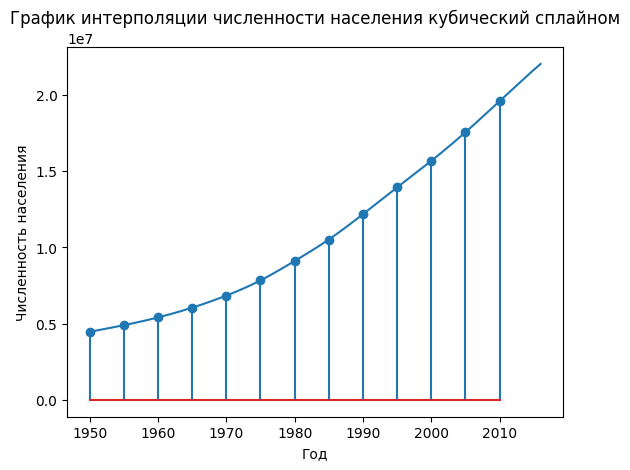

21643999.999999996


In [201]:
epsilon = 1e-9

def norm(vec):
    return np.max(np.abs(vec))

def solve_linear_system(A, f):
    N = len(f)
    x_old = np.array([0.0 for _ in range(N)])

    iterations = 0

    while norm(A @ x_old - f) >= epsilon:
        x_new = np.zeros(N)
        for i in range(N):
            for j in range(N):
                if i == j:
                    continue
                x_new[i] += A[i][j] * x_old[j]
            x_new[i] = (f[i] - x_new[i]) / A[i][i]
        x_old = x_new

    return x_old

A = np.zeros((N - 2, N - 2))
F = np.zeros(N - 2)

alpha = np.zeros(N - 1)
beta = np.zeros(N - 1)

for i in range(N - 2):
    A[i][i] = STEP * 2 / 3

for i in range(N - 3):
    A[i][i + 1] = STEP / 6
    A[i + 1][i] = STEP / 6    

for i in range(1, N - 1):
    F[i - 1] = (list(data.values())[i + 1] + list(data.values())[i - 1] - 2 * list(data.values())[i]) / STEP

M = np.array([0, *solve_linear_system(A, F), 0])


for i in range(N - 1):
    alpha[i] = list(data.values())[i] / STEP - M[i] * STEP / 6
    beta[i] = list(data.values())[i + 1] / STEP - M[i + 1] * STEP / 6

def spline(m, alpha, beta, t_i, t):
    n = len(t_i) - 2
    for i in range(len(t_i)):
        if t < t_i[i]:
            n = i - 1
            break
    return (m[n] * (t_i[n + 1] - t) ** 3 + m[n + 1] * (t - t_i[n]) ** 3) / (6 * STEP) + alpha[n] * (t_i[n + 1] - t) + beta[n] * (t - t_i[n])

def spline_vec(m, alpha, beta, t_i, t):
    res = []
    for a in t:
        res.append(spline(m, alpha, beta, t_i, a))
    return res

plt.stem(data.keys(), data.values())
plt.plot(np.linspace(1950, 2016, 1000), spline_vec(M, alpha, beta, list(data.keys()), np.linspace(1950, 2016, 1000)))

plt.xlabel("Год")
plt.ylabel("Численность населения")
plt.title("График интерполяции численности населения кубический сплайном")

plt.show()

print(spline(M, alpha, beta, list(data.keys()), 2015))

extraploation_result["Кубический сплайн"] = spline(M, alpha, beta, list(data.keys()), 2015)

### Экстраполируем данные методом наименьших квадратов выбрав экспоненциальную зависимость

$$ N = e^{a Y + b} $$
$$ \ln(N) = a Y + b $$
$$ \phi_1 = Y $$
$$ \phi_2 = 1 $$

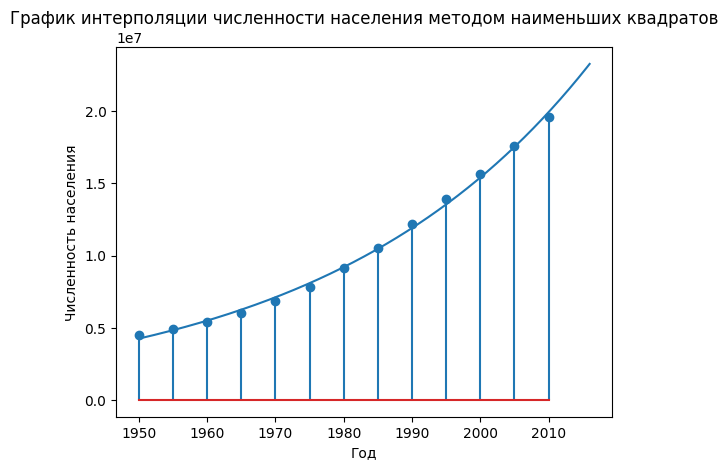

22676571.856689997


In [202]:
# Метод наименьших квадратов

def phi_1(Y):
    return Y

def phi_2(Y):
    return 1

def solve_linear_system(A, f):
    A_1 =np.array([
        np.array([A[1][1], -A[0][1]]),
        np.array([-A[1][0], A[0][0]]),
    ])
    
    det = A[0][0] * A[1][1] - A[0][1] * A[1][0]
    
    A_1 /= det
    
    return A_1 @ f

phi = [phi_1, phi_2]

x = np.array(list(data.keys()))
y = np.log(np.array(list(data.values())))

N = len(data)

A = np.array([
    np.zeros(2),
    np.zeros(2),
])

b = np.zeros(2)

for i in range(2):
    for j in range(2):
        A[i][j] = np.sum(np.array([phi[i](x[k]) * phi[j](x[k]) for k in range(N)]))
        
for i in range(2):
    b[i] = np.sum(np.array([y[k] * phi[i](x[k]) for k in range(N)]))
    
c = solve_linear_system(A, b)

plt.stem(data.keys(), data.values())
plt.plot(np.linspace(1950, 2016, 1000), np.exp(c[0] * np.linspace(1950, 2016, 1000) + c[1]))

plt.xlabel("Год")
plt.ylabel("Численность населения")
plt.title(f"График интерполяции численности населения методом наименьших квадратов")

plt.show()

print(np.exp(c[0] * 2015 + c[1]))

extraploation_result["Метод наименьших квадратов"] = np.exp(c[0] * 2015 + c[1])

In [203]:
extraploation_result["Официальные данные"] = 19958352

## Сравним полученный результат с данными из другого источника

Население Камеруна в 2015 году: 19958352 [Источник](https://en.wikipedia.org/wiki/List_of_countries_by_population_in_2015) 

In [204]:
import pandas as pd

res_table = {
    "Метод" : list(extraploation_result.keys()),
    "Численность населения" : list(extraploation_result.values()),
}

df = pd.DataFrame(res_table)
blankIndex=[''] * len(df)
df.index=blankIndex

df

,Метод,Численность населения
,Полином Ньютона,9.865100e+07
,Кубический сплайн,2.164400e+07
,Метод наименьших квадратов,2.267657e+07
,Официальные данные,1.995835e+07
